In [1]:
# This is a project created to recognize the diseases from Eye Fundus images.

In [2]:
import pandas as pd
import ast

In [3]:
import os


# root folder containing class folders
DATASET_ROOT = "newDataset"   # change if needed
OUTPUT_CSV = "neewDataSet_labels.csv"

data = []

for class_name in os.listdir(DATASET_ROOT):
    class_path = os.path.join(DATASET_ROOT, class_name)

    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            relative_path = os.path.join(class_name, file)
            data.append([relative_path, class_name])

# create dataframe
df = pd.DataFrame(data, columns=["filepath", "label"])

# save csv
# df.to_csv(OUTPUT_CSV, index=False)

print(f"CSV saved as {OUTPUT_CSV}")
print(df.head())

CSV saved as neewDataSet_labels.csv
                          filepath                 label
0     Diabetic Retinopathy\DR1.jpg  Diabetic Retinopathy
1    Diabetic Retinopathy\DR10.jpg  Diabetic Retinopathy
2   Diabetic Retinopathy\DR100.jpg  Diabetic Retinopathy
3  Diabetic Retinopathy\DR1000.jpg  Diabetic Retinopathy
4  Diabetic Retinopathy\DR1001.jpg  Diabetic Retinopathy


label
Diabetic Retinopathy    1509
Glaucoma                1349
Healthy                 1024
Myopia                   500
Name: count, dtype: int64


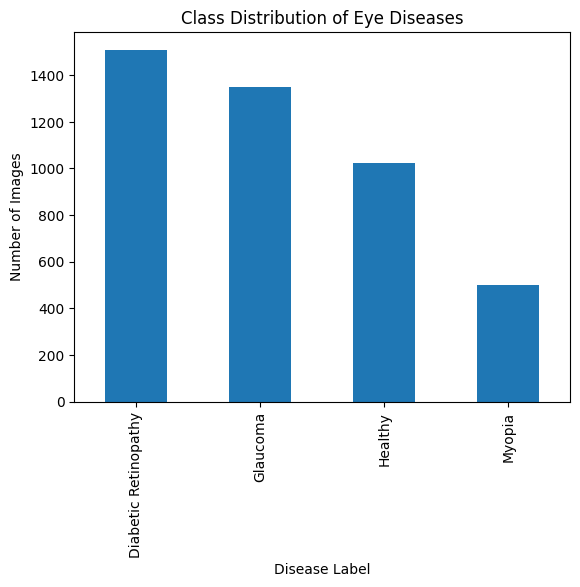

In [4]:
import matplotlib.pyplot as plt

class_counts = df["label"].value_counts()
print(class_counts)

plt.figure()
class_counts.plot(kind="bar")
plt.xlabel("Disease Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Eye Diseases")
plt.show()

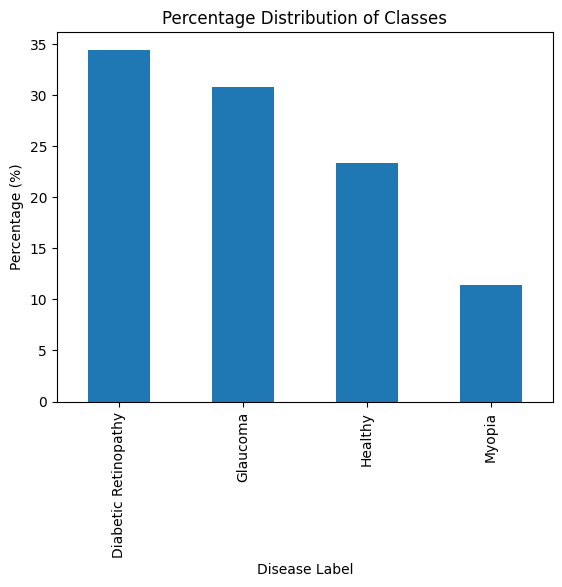

In [5]:
class_percent = class_counts / class_counts.sum() * 100

plt.figure()
class_percent.plot(kind="bar")
plt.ylabel("Percentage (%)")
plt.xlabel("Disease Label")
plt.title("Percentage Distribution of Classes")
plt.show()

Now lets do the pre processing steps to augment and enhance the image, by forming a dataset class

In [1]:
from torchvision import transforms

train_base_transforms = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_myopia_transforms = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.RandomHorizontalFlip(p=0.7),   # slightly higher
    transforms.RandomRotation(25),             # stronger geometry
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


test_transforms = transforms.Compose([
    transforms.Resize((518, 518)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import cv2
import numpy as np

def enhance_image_opencv(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    enhanced = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

    return enhanced

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import numpy as np

class EyeDataset(Dataset):
    def __init__(self, csv_file, image_dir,
                 transform_base,
                 transform_myopia,
                 enhance=False):

        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.enhance = enhance

        
        self.base_transform = transform_base
        self.myopia_transform = transform_myopia

        self.label_map = {
            "Diabetic Retinopathy": 0,
            "Glaucoma": 1,
            "Healthy": 2,
            "Myopia": 3,
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.image_dir,
            self.data.iloc[idx]["filepath"]
        )

        image = Image.open(img_path).convert("RGB")

        if self.enhance:
            image_np = np.array(image)
            image_np = enhance_image_opencv(image_np)
            image = Image.fromarray(image_np)

        label_str = self.data.iloc[idx]["label"]

        if label_str == "Myopia" and self.myopia_transform is not None:
            image = self.myopia_transform(image)
        else:
            image = self.base_transform(image)

        label = self.label_map[label_str]

        return image, label


Split the dataset

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

train_df.to_csv("newTrain.csv", index=False)
test_df.to_csv("newTest.csv", index=False)


In [8]:
train_dataset = EyeDataset(
    csv_file="newTrain.csv",
    image_dir=DATASET_ROOT,
    transform_base= train_base_transforms,
    transform_myopia= train_myopia_transforms,
    enhance=True  
)

test_dataset = EyeDataset(
    csv_file="newTest.csv",
    image_dir=DATASET_ROOT,
    transform_base= test_transforms,
    transform_myopia=None,
    enhance=False 
)


In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Phase 1 training resnet freezed and vit small gets the parameter updates during back propagation

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm


class ResNet_DINOv2_Hybrid(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # 1. ResNet50 backbone (FROZEN)
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False

        # Remove avgpool and fc → keep spatial feature map
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        # Output: [B, 2048, ~16, ~16] for 518x518 input

        # 2. Projection layer (2048 → 384)

        self.proj = nn.Linear(2048, 384)

        # 3. DINOv2 ViT-small with registers

        self.vit = timm.create_model(
            "vit_small_patch14_reg4_dinov2.lvd142m",
            pretrained=True,
            num_classes=0  # removes classification head
        )

        # 4. Final classifier
        self.classifier = nn.Linear(384, num_classes)

    def forward(self, x):
        # ResNet feature extraction
        feats = self.resnet(x)
        # [B, 2048, H, W] ≈ [B, 2048, 16, 16]

        B, C, H, W = feats.shape

        # Convert feature map to tokens
        tokens = feats.flatten(2).permute(0, 2, 1)
        # [B, H*W, 2048] → [B, 256, 2048]

        # Project to ViT embedding
        tokens = self.proj(tokens)
        # [B, 256, 384]


        # Class token
        cls_token = self.vit.cls_token.expand(B, -1, -1) # type: ignore

        # Register tokens (DINOv2 specific)
        reg_tokens = self.vit.reg_token.expand(B, -1, -1) # type: ignore

        # Concatenate: [CLS][REG][PATCH TOKENS]
        x = torch.cat((cls_token, reg_tokens, tokens), dim=1)

        # Add positional embeddings
        x = x + self.vit.pos_embed[:, : x.size(1), :] # type: ignore
        x = self.vit.pos_drop(x) # type: ignore

        # Transformer blocks
        for blk in self.vit.blocks: # type: ignore
            x = blk(x)

        x = self.vit.norm(x) # type: ignore

        # Take CLS token output
        vit_out = x[:, 0]

        # ---- Classification ----
        out = self.classifier(vit_out)
        return out



In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import timm


# class ResNet_DINOv2_Hybrid(nn.Module):
#     def __init__(self, num_classes=4):
#         super().__init__()

#         # 1. ResNet50 backbone (FROZEN)
#         resnet = models.resnet50(pretrained=True)
#         for param in resnet.parameters():
#             param.requires_grad = False

#         # Remove avgpool and fc → keep spatial feature map
#         self.resnet = nn.Sequential(*list(resnet.children())[:-2])
#         # Output: [B, 2048, ~16, ~16] for 518x518 input

#         # 2. Projection layer (2048 → 384)

#         self.proj = nn.Linear(2048, 384)

#         # 3. DINOv2 ViT-small with registers

#         self.vit = timm.create_model(
#             "vit_small_patch14_reg4_dinov2.lvd142m",
#             pretrained=True,
#             num_classes=0  # removes classification head
#         )

#         # 4. Final classifier
#         self.classifier = nn.Linear(384, num_classes)
#     def forward(self, x):
#     # 1. ResNet features
#     feats = self.resnet(x) # [B, 2048, H, W]
#     B, C, H, W = feats.shape
    
#     # 2. Tokenize and Project
#     tokens = feats.flatten(2).permute(0, 2, 1) # [B, HW, 2048]
#     tokens = self.proj(tokens) # [B, HW, 384]

#     # 3. Assemble tokens (CLS + REG + PATCHES)
#     cls_token = self.vit.cls_token.expand(B, -1, -1)
#     reg_tokens = self.vit.reg_token.expand(B, -1, -1)
    
#     # Combine all
#     x = torch.cat((cls_token, reg_tokens, tokens), dim=1)

#     # 4. Position Embedding (CRITICAL SHAPE CHECK)
#     # If x.size(1) != pos_embed.size(1), you'll need to interpolate pos_embed
#     if x.size(1) != self.vit.pos_embed.size(1):
#         # You may need to resize pos_embed here if your image size varies
#         pass 
    
#     x = x + self.vit.pos_embed
#     x = self.vit.pos_drop(x)

#     # 5. Blocks (Using timm's internal sequence is safer)
#     x = self.vit.blocks(x)
#     x = self.vit.norm(x)

#     # 6. Classification Head (take CLS token)
#     return self.classifier(x[:, 0])

In [14]:
x = torch.randn(2, 3, 518, 518).cuda()
model = ResNet_DINOv2_Hybrid().cuda()
y = model(x)
print(y.shape)  # MUST be [2, 8]


torch.Size([2, 4])


In [11]:
import matplotlib.pyplot as plt

In [12]:
def accuracy_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


In [26]:
def train_phase(
    model,
    train_loader,
    val_loader,
    optimizer,
    chkpointname,
    scheduler,
    epochs=15,
    device="cuda"
):
    model.to(device)
    # Order: DR, Glaucoma, Healthy, Myopia
    weights = [1.0, 1.0, 0.8, 1.5]
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        # ------------------ TRAIN ------------------
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy_fn(outputs, labels)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = running_acc / len(train_loader)

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        scheduler.step()

        # ------------------ VALIDATION ------------------
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                # labels = torch.tensor(labels, dtype=torch.long).to(device)
                labels = labels.to(device)


                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += accuracy_fn(outputs, labels)

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_acc / len(val_loader)

        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, "
            f"Val Acc: {epoch_val_acc:.4f}"
        )

        # ------------------ SAVE BEST MODEL ------------------
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "epoch": epoch + 1,
                    "val_acc": best_val_acc
                },
                chkpointname
            )
            print("✅ Best model saved")

    return train_losses, train_accs, val_losses, val_accs


In [28]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.show()


In [19]:
sample_img, sample_label = train_dataset[0]
print(sample_label, type(sample_label))


0 <class 'int'>


In [20]:
model = ResNet_DINOv2_Hybrid(num_classes=4)

In [21]:
optimizer_phase1 = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=3e-4
    )

In [22]:
scheduler_phase1 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase1,
    T_max=15,      # same as epochs
    eta_min=1e-6
)


Epoch [1/15]
Train Loss: 1.1417, Train Acc: 0.4798 | Val Loss: 1.1723, Val Acc: 0.4348
✅ Best model saved

Epoch [2/15]
Train Loss: 0.7171, Train Acc: 0.6540 | Val Loss: 1.2871, Val Acc: 0.4320

Epoch [3/15]
Train Loss: 0.6002, Train Acc: 0.7024 | Val Loss: 0.8536, Val Acc: 0.6055
✅ Best model saved

Epoch [4/15]
Train Loss: 0.5581, Train Acc: 0.7435 | Val Loss: 1.3247, Val Acc: 0.4877

Epoch [5/15]
Train Loss: 0.4890, Train Acc: 0.7933 | Val Loss: 1.0787, Val Acc: 0.5355

Epoch [6/15]
Train Loss: 0.4658, Train Acc: 0.7978 | Val Loss: 0.7431, Val Acc: 0.6834
✅ Best model saved

Epoch [7/15]
Train Loss: 0.4415, Train Acc: 0.8163 | Val Loss: 1.0572, Val Acc: 0.5907

Epoch [8/15]
Train Loss: 0.4069, Train Acc: 0.8280 | Val Loss: 0.7929, Val Acc: 0.6805

Epoch [9/15]
Train Loss: 0.3905, Train Acc: 0.8386 | Val Loss: 2.3207, Val Acc: 0.3002

Epoch [10/15]
Train Loss: 0.4014, Train Acc: 0.8363 | Val Loss: 0.8236, Val Acc: 0.6720

Epoch [11/15]
Train Loss: 0.3720, Train Acc: 0.8408 | Val Los

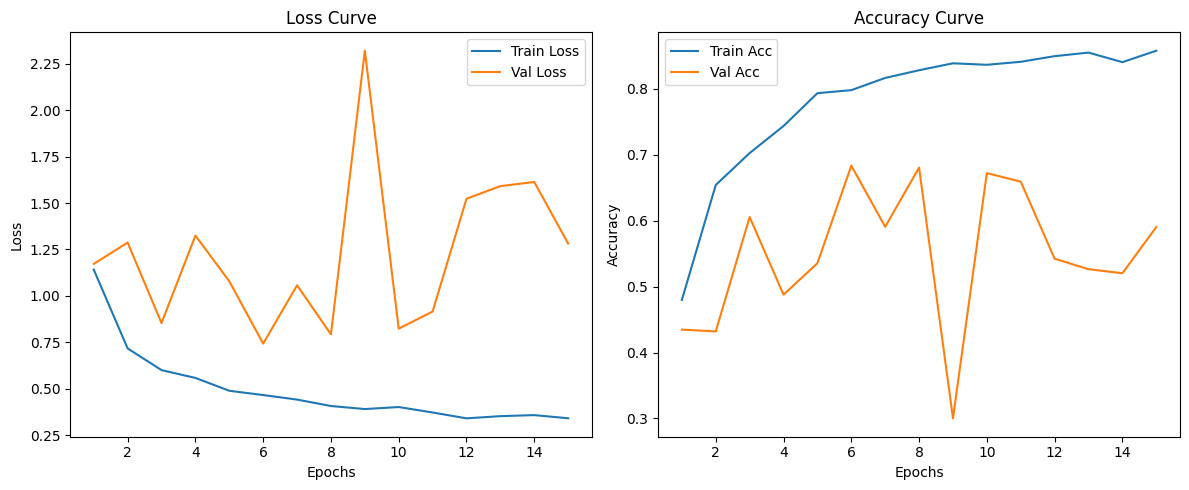

In [23]:
train_losses, train_accs, val_losses, val_accs = train_phase(
    model,
    train_loader,
    val_loader,
    optimizer=optimizer_phase1,
    chkpointname="model_1__alt_phase1_training_partial_best.pth",
    scheduler=scheduler_phase1,
    epochs=15,
    device="cuda"
)

plot_metrics(train_losses, val_losses, train_accs, val_accs)


Phase 2 starts

In [25]:
model_2 = ResNet_DINOv2_Hybrid(num_classes=4) 

In [26]:
ckpt = torch.load(
    "model_1__alt_phase1_training_partial_best.pth",
    map_location="cuda"
)

model_2.load_state_dict(ckpt["model_state"])
model_2.to("cuda")

ResNet_DINOv2_Hybrid(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [27]:
# Freeze ResNet completely
for p in model_2.resnet.parameters():
    p.requires_grad = False

# Unfreeze ViT
for p in model_2.vit.parameters():
    p.requires_grad = True

# Ensure projection + classifier are trainable
for p in model_2.proj.parameters():
    p.requires_grad = True

for p in model_2.classifier.parameters():
    p.requires_grad = True


In [28]:
optimizer_phase2 = torch.optim.AdamW(
    [
        {"params": model_2.vit.parameters(), "lr": 1e-4},
        {"params": model_2.proj.parameters(), "lr": 3e-4},
        {"params": model_2.classifier.parameters(), "lr": 3e-4},
    ],
    weight_decay=1e-4
)


In [29]:
scheduler_phase2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase2,
    T_max=15,      # same as epochs
    eta_min=1e-6
)

In [30]:
sum(p.numel() for p in model_2.vit.parameters() if p.requires_grad)

22057344


Epoch [1/15]
Train Loss: 0.4600, Train Acc: 0.8124 | Val Loss: 1.4454, Val Acc: 0.4566
✅ Best model saved

Epoch [2/15]
Train Loss: 0.4417, Train Acc: 0.8178 | Val Loss: 1.3194, Val Acc: 0.4455

Epoch [3/15]
Train Loss: 0.4055, Train Acc: 0.8329 | Val Loss: 1.0790, Val Acc: 0.5891
✅ Best model saved

Epoch [4/15]
Train Loss: 0.4141, Train Acc: 0.8274 | Val Loss: 1.0995, Val Acc: 0.6039
✅ Best model saved

Epoch [5/15]
Train Loss: 0.4024, Train Acc: 0.8252 | Val Loss: 2.6868, Val Acc: 0.4082

Epoch [6/15]
Train Loss: 0.3944, Train Acc: 0.8300 | Val Loss: 0.9802, Val Acc: 0.6218
✅ Best model saved

Epoch [7/15]
Train Loss: 0.3857, Train Acc: 0.8368 | Val Loss: 0.9946, Val Acc: 0.6032

Epoch [8/15]
Train Loss: 0.3640, Train Acc: 0.8460 | Val Loss: 1.2305, Val Acc: 0.5661

Epoch [9/15]
Train Loss: 0.3543, Train Acc: 0.8451 | Val Loss: 1.2010, Val Acc: 0.5382

Epoch [10/15]
Train Loss: 0.3408, Train Acc: 0.8556 | Val Loss: 1.4524, Val Acc: 0.5434

Epoch [11/15]
Train Loss: 0.3253, Train Ac

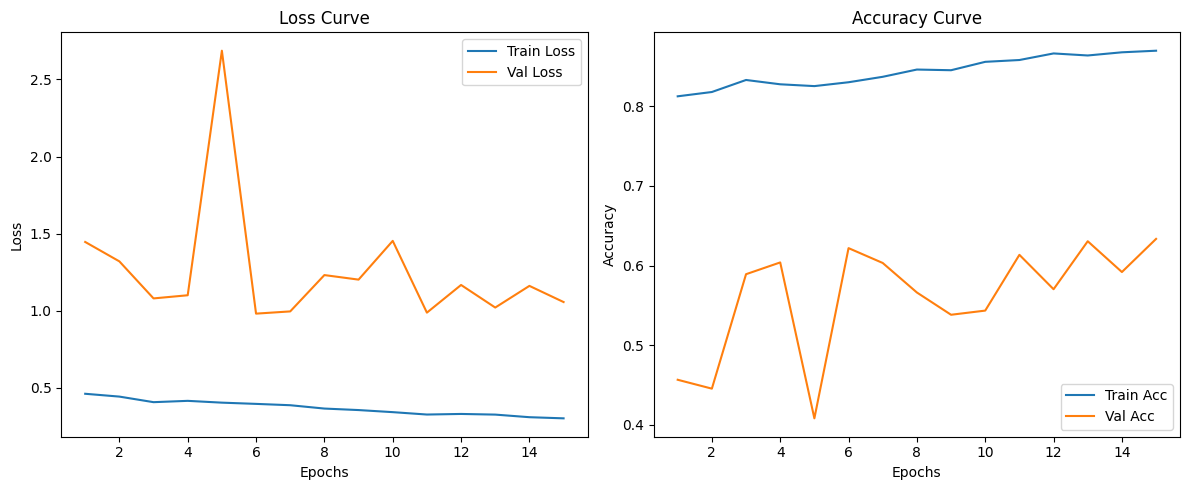

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_phase(
    model_2,
    train_loader,
    val_loader,
    optimizer=optimizer_phase2,
    chkpointname="model_1_alt_phase2_training_partial_best.pth",
    scheduler=scheduler_phase2,
    epochs=15,
    device="cuda")

plot_metrics(train_losses, val_losses, train_accs, val_accs)

Now lets start phase 3 by unfreezing the layer 4 of the resnet to allow partial learning

In [18]:
model_3 = ResNet_DINOv2_Hybrid(num_classes=4) 

In [19]:
checkpoint = torch.load("model_1_alt_phase2_training_partial_best.pth")
model_3.load_state_dict(checkpoint["model_state"])


<All keys matched successfully>

In [20]:
for p in model_3.parameters():
    p.requires_grad = False


vit params openend

In [21]:
for p in model_3.vit.parameters():
    p.requires_grad = True

for p in model_3.proj.parameters():
    p.requires_grad = True

for p in model_3.classifier.parameters():
    p.requires_grad = True


Now lets focus on releasing the params of resnet

In [22]:
for name, module in model_3.resnet.named_children():
    if name in ["layer3", "layer4"]:
        for p in module.parameters():
            p.requires_grad = True


In [23]:
optimizer_phase3 = torch.optim.AdamW(
    [
        # ResNet (very small LR)
        {
            "params": [
                p for n, p in model_3.resnet.named_parameters()
                if p.requires_grad
            ],
            "lr": 1e-5
        },

        # ViT backbone
        {
            "params": model_3.vit.parameters(),
            "lr": 5e-5
        },

        # Projection + classifier
        {
            "params": list(model_3.proj.parameters()) +
                      list(model_3.classifier.parameters()),
            "lr": 1e-4
        },
    ],
    weight_decay=1e-4
)


In [24]:
scheduler_phase3 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase3,
    T_max=15,      # same as epochs
    eta_min=1e-6
)

In [38]:
sum(p.numel() for p in model_3.parameters() if p.requires_grad)


22846085

In [27]:
train_losses, train_accs, val_losses, val_accs = train_phase(
    model_3,
    train_loader,
    val_loader,
    optimizer=optimizer_phase3,
    chkpointname="model_1_alt_phase3_training_partial_best.pth",
    scheduler=scheduler_phase3,
    epochs=15,
    device="cuda")

plot_metrics(train_losses, val_losses, train_accs, val_accs)


Epoch [1/15]
Train Loss: 0.3295, Train Acc: 0.8551 | Val Loss: 1.3038, Val Acc: 0.6043
✅ Best model saved

Epoch [2/15]
Train Loss: 0.3255, Train Acc: 0.8636 | Val Loss: 0.9708, Val Acc: 0.6430
✅ Best model saved

Epoch [3/15]
Train Loss: 0.3289, Train Acc: 0.8630 | Val Loss: 1.5259, Val Acc: 0.5286

Epoch [4/15]
Train Loss: 0.3240, Train Acc: 0.8619 | Val Loss: 0.9037, Val Acc: 0.6630
✅ Best model saved

Epoch [5/15]
Train Loss: 0.3133, Train Acc: 0.8636 | Val Loss: 0.8093, Val Acc: 0.7005
✅ Best model saved

Epoch [6/15]
Train Loss: 0.3119, Train Acc: 0.8633 | Val Loss: 0.8790, Val Acc: 0.6584

Epoch [7/15]
Train Loss: 0.3075, Train Acc: 0.8707 | Val Loss: 0.8817, Val Acc: 0.6845

Epoch [8/15]
Train Loss: 0.3109, Train Acc: 0.8667 | Val Loss: 1.3770, Val Acc: 0.5877

Epoch [9/15]
Train Loss: 0.2952, Train Acc: 0.8722 | Val Loss: 1.4364, Val Acc: 0.5832

Epoch [10/15]
Train Loss: 0.2853, Train Acc: 0.8716 | Val Loss: 1.0888, Val Acc: 0.6366

Epoch [11/15]
Train Loss: 0.2760, Train Ac

NameError: name 'plot_metrics' is not defined

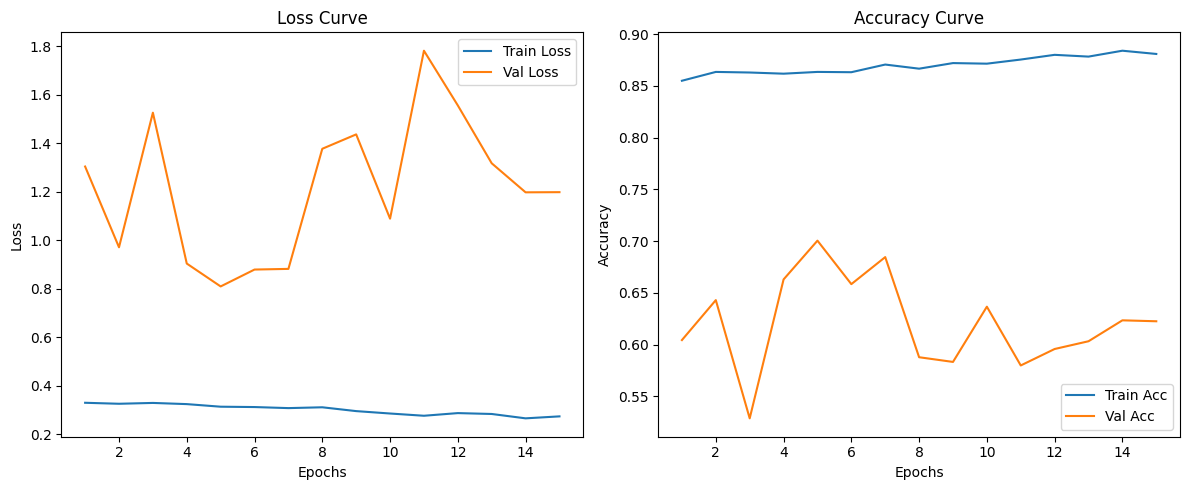

In [29]:
plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [4]:
device = "cuda"

# 1. Recreate the model architecture FIRST
model = ResNet_DINOv2_Hybrid(num_classes=4)   # use exact same args
model = model.to(device)

# 2. Load weights
state_dict = torch.load("model_1_alt_phase3_training_partial_best.pth", map_location=device)
model.load_state_dict(state_dict["model_state"])

# 3. Set to eval mode (VERY IMPORTANT)
model.eval()

c:\Users\Vijay Anand\Documents\Programming\collegeProject\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vijay Anand\Documents\Programming\collegeProject\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet_DINOv2_Hybrid(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report

all_preds = []
all_labels = []



with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

label_map = {
            "Diabetic Retinopathy": 0,
            "Glaucoma": 1,
            "Healthy": 2,
            "Myopia": 3,
        }

class_names = [
    "Diabetic Retinopathy",
    "Glaucoma",
    "Healthy",
    "Myopia"
]
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
)

print(report)


                      precision    recall  f1-score   support

Diabetic Retinopathy     0.9953    0.7020    0.8233       302
            Glaucoma     0.6088    0.7667    0.6787       270
             Healthy     0.7228    0.6488    0.6838       205
              Myopia     0.4429    0.6200    0.5167       100

            accuracy                         0.7001       877
           macro avg     0.6925    0.6844    0.6756       877
        weighted avg     0.7496    0.7001    0.7112       877



In [3]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.fwd_handle = self.target_layer.register_forward_hook(self._forward_hook)
        self.bwd_handle = self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        score = output[:, class_idx]
        score.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients not captured")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (518, 518))
        cam = cam / (cam.max() + 1e-8)
        return cam

    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()


In [5]:
target_layer = model.resnet[-1-1][-1] 
print(type(target_layer))


<class 'torchvision.models.resnet.Bottleneck'>


In [6]:
def enable_gradcam(model):
    for p in model.resnet.parameters():
        p.requires_grad = True


In [7]:
import torch
import cv2
import numpy as np
from PIL import Image

def infer_with_gradcam(
    image_path,
    model,
    gradcam,
    transform,
    device,
    class_names,
    save_path="gradcam_output.png"
):
    enable_gradcam(model)
    model.eval()

    # ---- Load original image ----
    original_img = Image.open(image_path).convert("RGB")
    original_np = np.array(original_img)

    # ---- Preprocess ----
    img = transform(original_img)
    img = img.unsqueeze(0).to(device)

    # ---- Pass 1: Prediction ----
    with torch.no_grad():
        output = model(img)
        pred_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0, pred_class].item()

    # ---- Pass 2: Grad-CAM ----
    cam = gradcam.generate(img, pred_class)

    # ---- Resize original image to CAM size ----
    original_np = cv2.resize(original_np, (518, 518))

    # ---- Overlay ----
    heatmap = cv2.applyColorMap(np.uint8(255 * cam),cv2.COLORMAP_JET) # type: ignore

    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = np.uint8(0.6 * original_np + 0.4 * heatmap)

    # ---- Save result ----
    cv2.imwrite(save_path, overlay)

    return {
        "predicted_class": class_names[pred_class],
        "confidence": round(confidence, 4),
        "gradcam_path": save_path
    }


In [8]:
target_layer = model.resnet[-1-1][-1]   # last Bottleneck
gradcam = GradCAM(model, target_layer)


In [12]:
class_names = [
    "Diabetic Retinopathy",
    "Glaucoma",
    "Healthy",
    "Myopia"
]

result = infer_with_gradcam(
    image_path=r"newDataset\Diabetic Retinopathy\DR1515.jpg",
    model=model,
    gradcam=gradcam,
    transform=train_base_transforms,
    device=device,
    class_names=class_names,
    save_path="sample_gradcam.png"
)

print(result)


{'predicted_class': 'Diabetic Retinopathy', 'confidence': 0.9943, 'gradcam_path': 'sample_gradcam.png'}
